In [ ]:
# Load Libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt

In [ ]:
# Seed
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/Entire_Signal/CNN_With_Spectra/CNN_Models/Hyperparameter_Tuning_CNN_spectra/Model_5/Input_Output_Data_Model_5.mat')
df = pd.DataFrame({'F1':data1['F1'].flatten(), 'F2':data1['F2'].flatten(), 'F3':data1['F3'].flatten(), 'F4':data1['F4'].flatten(), 'F5':data1['F5'].flatten(),
                   'F6':data1['F6'].flatten(),'SS':data1['SS'].flatten()})
df = df[['F1','F2','F3','F4','F5','F6','SS']]

In [ ]:
# Preprocessing (SS)
arr = df.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132106, 300, 6)
Target shape (SS), Y =  (132106,)
After reshaping, X =  (132106, 1800)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train))
print("Validation samples:", np.shape(X_val))
print("Testing samples:", np.shape(x_test))

Training samples: (92473, 1800)
Validation samples: (13211, 1800)
Testing samples: (26422, 1800)


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(1800,),name='X_train')

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(1024,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(256,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(64, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ X_train (InputLayer)            │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,844,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,123,137 (8.10 MB)

 Trainable params: 2,123,137 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0143 - mse: 0.0143
Epoch 1: val_loss improved from inf to 0.00702, saving model to /content/drive/My Drive/Colab Notebooks/Entire_Signal/Automatic_Features_Extraction/New_AFE_Models/MLP_Model_With_Extracted_Features/Check.keras
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 94s 32ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 2/100
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0025 - mse: 0.0025
Epoch 2: val_loss improved from 0.00702 to 0.00475, saving model to /content/drive/My Drive/Colab Notebooks/Entire_Signal/Automatic_Features_Extraction/New_AFE_Models/MLP_Model_With_Extracted_Features/Check.keras
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 134s 29ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 3/100
2888/2890 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0019 - mse: 0.0019
Epoch 3: val_loss did not improve from 0.00475
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 141s 29ms/step - loss:

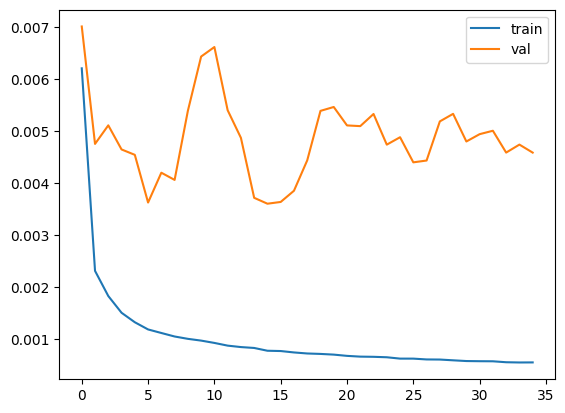

---Training time: 4337.67513180 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Entire_Signal/Automatic_Features_Extraction/New_AFE_Models/MLP_Model_With_Extracted_Features/Check.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# Model Performance: Training
y_predtrain = model.predict(X_train)
y_predtrain_SS = np.array(y_predtrain)

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS)
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS))

# Model Performance: Validation
y_predval = model.predict(X_val)
y_predval_SS = np.array(y_predval)

val_r2_SS = r2_score(Y_val_SS, y_predval_SS)
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS))

# Model Performance: Testing
y_predtest = model.predict(x_test)
y_predtest_SS =np.array(y_predtest)

test_r2_SS = r2_score(y_test_SS,y_predtest_SS)
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS))

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f" %(train_r2_SS))
print("R2 scores: Validation (SS) - %0.5f" %(val_r2_SS))
print("R2 scores: Testing (SS) - %0.5f" %(test_r2_SS))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f" %(train_rmse_SS))
print("RMSE scores: Validation (SS) - %0.5f" %(val_rmse_SS))
print("RMSE scores: Testing (SS) - %0.5f" %(test_rmse_SS))

   5/2890 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step   

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X_train']
Received: inputs=Tensor(shape=(32, 1800))
  warnings.warn(msg)


2890/2890 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X_train']
Received: inputs=Tensor(shape=(None, 1800))
  warnings.warn(msg)


413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
R2 scores: Train (SS) - 0.98254
R2 scores: Validation (SS) - 0.87047
R2 scores: Testing (SS) - -0.99911
RMSE scores: Train (SS) - 0.02154
RMSE scores: Validation (SS) - 0.06772
RMSE scores: Testing (SS) - 0.26059
